In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict



from dotenv import load_dotenv
load_dotenv()

True

In [7]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

mlflow experiment set to: NW2_scour


In [8]:
from owi_data_2_pandas.io import API

user = os.getenv('API_USERNAME') 
password = os.getenv('API_PASSWORD')
root = r"http://10.0.0.138/api/v1/"
owi = API(api_root=root, username=user, password=password)

In [9]:
owi.groups
locations = owi.groups[owi.groups['project'] == 'northwester2_iot']['locations'].values[0]

In [10]:
# Data Paths
data_root = "../../../"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
mvbc_data = pd.read_parquet(mvbc_path)

In [11]:
#Hyperopt functions for hyperparameter optimizations

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


seed = 2
def objective_xgb(space):
    model = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
                )
            ]
        )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='r2').mean()
    # We aim to maximize r2 score, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }

def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,500),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            rstate = np.random.default_rng(seed)
            )
    return best

In [12]:
from oma_tracking.data.make_dataset import DatasetGetter

start  = datetime.datetime(2023,1,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)


site = 'NorthWester2'
site_id = 'NW2'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'


for location in locations[0:1]:
    name_location = '_'.join(['NW2', location.split('nw2')[1].upper()])
    print(name_location)
    dsg = DatasetGetter(start, stop, location)
    dsg.get_longterm_data()

    weather_inputs = make_dataset.get_weather_subset(mvbc_data)
    scada_inputs = make_dataset.get_scada_subset(dsg.data)


NW2_E02


In [13]:
def get_tracked_frequencies(
        location,
        mode = 'SS1',
        data_path = r"C:\Users\Max\Documents\OWI_LAB\Code\Packages\oma_tracking\data\nw2\tracked_modes"
    ) -> pd.DataFrame:
    location_tag = ''.join(['NW2', location.split('nw2')[1].upper()])
    file_name = '_'.join([mode, location_tag])
    file_path = os.path.join(data_path, file_name + '.parquet')
    return pd.read_parquet(file_path)

In [14]:
data = dsg.data
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)
inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )
inputs = inputs[~inputs.index.duplicated(keep='first')]

In [15]:
import mlflow
mlflow.start_run()
# Disable autologging
mlflow.sklearn.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)
mlflow.end_run()


nw2e02
SS1
100%|██████████| 50/50 [01:41<00:00,  2.02s/trial, best loss: -0.5618157607353859]
{'colsample_bytree': 0.2331485067254925, 'learning_rate': 0.04523401011818849, 'max_depth': 3, 'n_estimators': 218}
before optimization
XGB MSE: 9.379108543097624e-06 R2: 0.48802452298866983
after optimization
XGB MSE: 7.85038131147e-06 R2: 0.5714728432673337


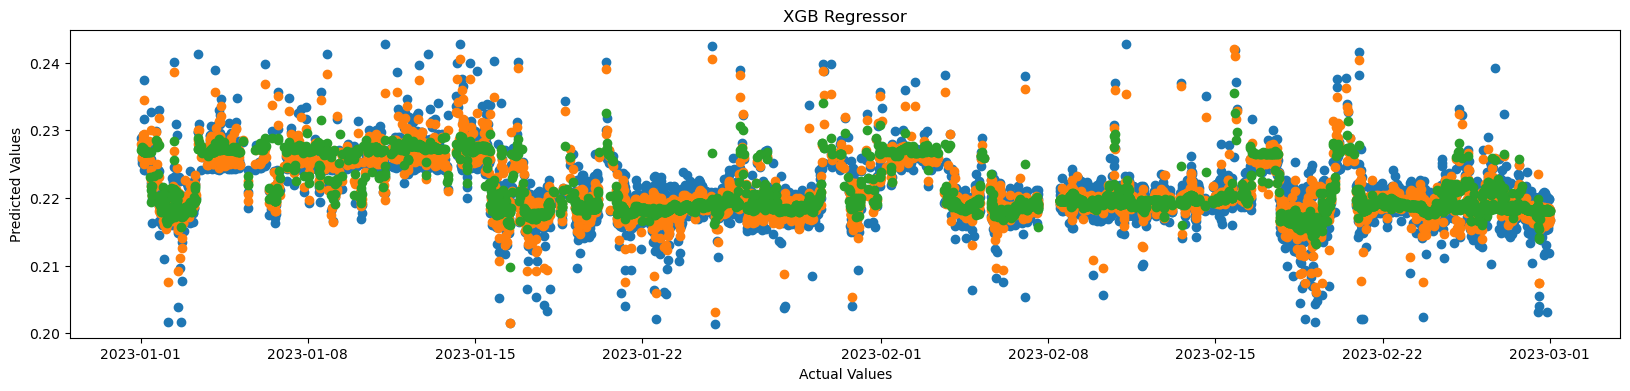

SS2
100%|██████████| 50/50 [02:41<00:00,  3.24s/trial, best loss: -0.6269448189596645]
{'colsample_bytree': 0.5011074702141722, 'learning_rate': 0.03480163495830837, 'max_depth': 7, 'n_estimators': 364}
before optimization
XGB MSE: 0.000261109382122919 R2: 0.6644914861167602
after optimization
XGB MSE: 0.00025295743345883734 R2: 0.6749662080869228


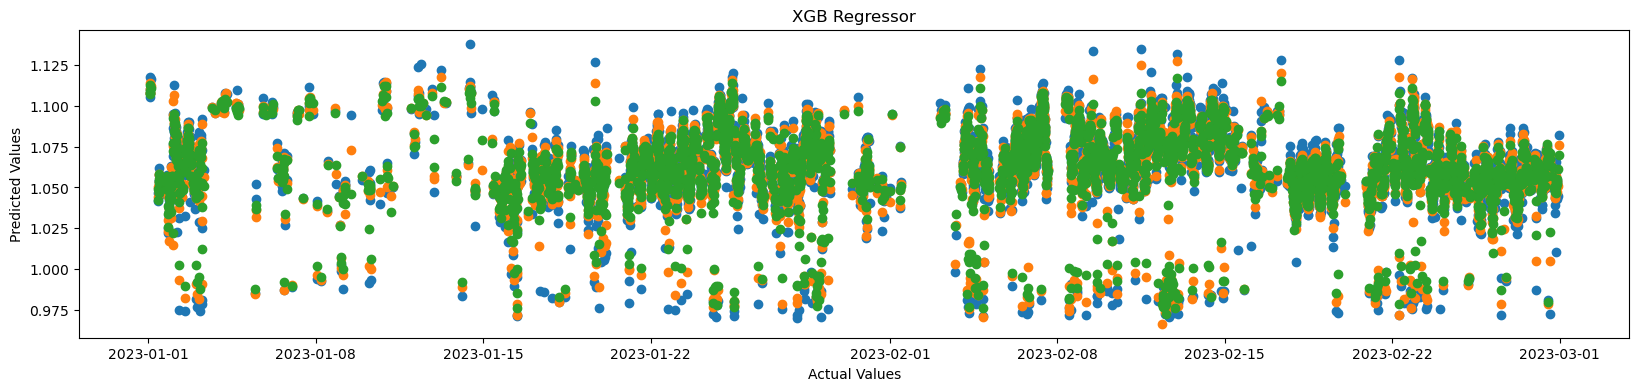

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import mlflow

site = 'NorthWester2'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'

hyperopt_folder = data_root + "data/nw2/model_hyperopt/" + location + "_"
nb_path = os.getcwd()

for location in locations[0:1]:
    print(location)
    XGB_optimizations = {}
    for mode in ['SS1', 'SS2']:
        print(mode)
        prediction_param = get_tracked_frequencies(location, mode)['frequency']
        prediction_param = pd.DataFrame(prediction_param)
        prediction_param = prediction_param[~prediction_param.index.duplicated(keep='first')] # type: ignore

        test_size = 0.2
        random_state = 42

        y = prediction_param.dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)

        regr_xgb = \
                    Pipeline(
                        steps=[
                            ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                            ('regressor', XGBRegressor())
                            ])
        regr_xgb.fit(X_train, y_train)

        

        y_pred = regr_xgb.predict(X_test)
        regr_xgb_mse = mean_squared_error(y_test, y_pred)
        regr_xgb_r2 = r2_score(y_test, y_pred)

        #Hyperparameter optimization
        XGB_optimizations = {}
        prediction_param = get_tracked_frequencies(location, mode)['frequency']
        prediction_param = pd.DataFrame(prediction_param)
        prediction_param = prediction_param[~prediction_param.index.duplicated(keep='first')] # type: ignore
        
        trial2=Trials()
        XGB_optimizations[mode]=optimize_xgb(trial2)
        XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]
        print(XGB_optimizations[mode])

        run_name = \
            '_'.join(
                [
                    name_location,
                    type,
                    model_function,
                    datetime.datetime.today().strftime('%Y-%m-%d')
                ]
            )

        site_id = name_location.split('_')[0]
        location_id = name_location.split('_')[1]

        tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
        }

        with mlflow.start_run(tags=tags, run_name=run_name):
            mlflow.autolog(log_models=True, exclusive=False)

            regr_xgb_optimized = \
                Pipeline(
                    steps=[
                        ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                        ('regressor', XGBRegressor(
                            n_estimators = XGB_optimizations[mode]['n_estimators'],
                            max_depth = XGB_optimizations[mode]['max_depth'],
                            learning_rate = XGB_optimizations[mode]['learning_rate'],
                            colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                            )
                        )
                    ]
                )

            regr_xgb_optimized.fit(X_train, y_train)

            metrics = mlflow.sklearn.eval_and_log_metrics(
                    regr_xgb_optimized, X_test, y_test, prefix="test_"
                    )

            params = {
                        "model function": 'normalization',
                        "prediction_parameter": str(mode),
                        "time_period": str(start) + ' - ' + str(stop),
                        "data_random_state": random_state,
                        "test_size": test_size,
                        "notebook": nb_path,
                        "model": str([step[1].__class__ for step in regr_xgb_optimized.steps])
                    }
                
            mlflow.log_params(params)                
            signature = infer_signature(X_test, regr_xgb_optimized.predict(X_test))
            mlflow.autolog(disable=True)
            mlflow.sklearn.autolog(disable=True)
            mlflow.xgboost.autolog(disable=True)
            mlflow.end_run()

        # Print the metrics
        print('before optimization')
        print("XGB MSE:", regr_xgb_mse, "R2:", regr_xgb_r2)

        print('after optimization')
        print("XGB MSE:", metrics['test_mse'], "R2:", metrics['test_r2_score'])

        # Create scatter plot of predicted vs. actual values for best xgb regressor
        plt.figure(figsize=(20, 4))
        plt.scatter(y.index, y, label='Actual Values')
        plt.scatter(y.index, regr_xgb.predict(X), label='Predicted Values')
        plt.scatter(y.index, regr_xgb_optimized.predict(X), label='Predicted Values Optimization')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('XGB Regressor')
        plt.show()

    pd.DataFrame(XGB_optimizations).to_csv(hyperopt_folder + mode + ".csv")

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

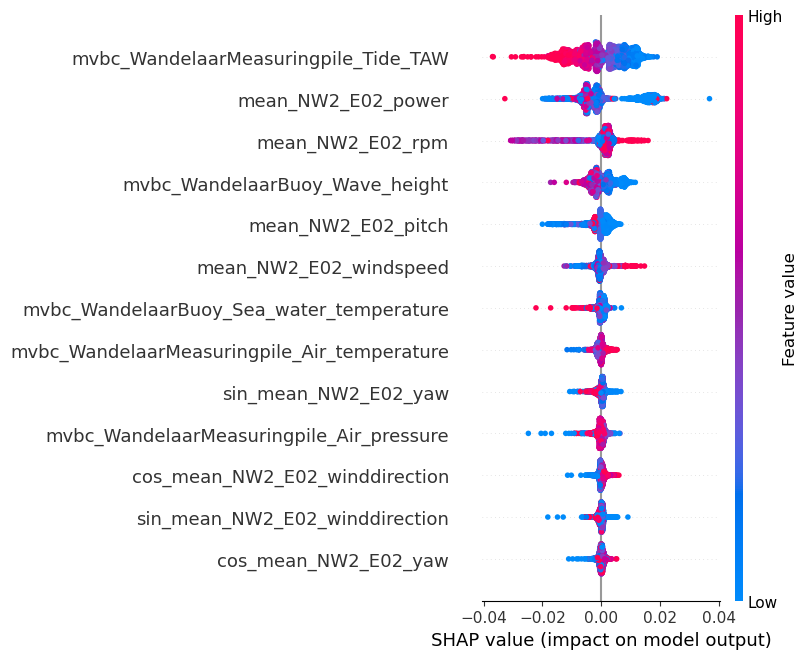

In [13]:
import shap

explainer = shap.Explainer(regr_xgb_optimized['regressor'])
shap_values = explainer(regr_xgb_optimized['preprocessing_angles'].transform(X))
shap_summary_plot = shap.summary_plot(shap_values, regr_xgb_optimized['preprocessing_angles'].transform(X))

In [14]:
regr_xgb_optimized['preprocessing_angles'].transform(X).columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_E02_rpm',
       'mean_NW2_E02_pitch', 'mean_NW2_E02_power', 'mean_NW2_E02_windspeed',
       'sin_mean_NW2_E02_yaw', 'cos_mean_NW2_E02_yaw',
       'sin_mean_NW2_E02_winddirection', 'cos_mean_NW2_E02_winddirection'],
      dtype='object')

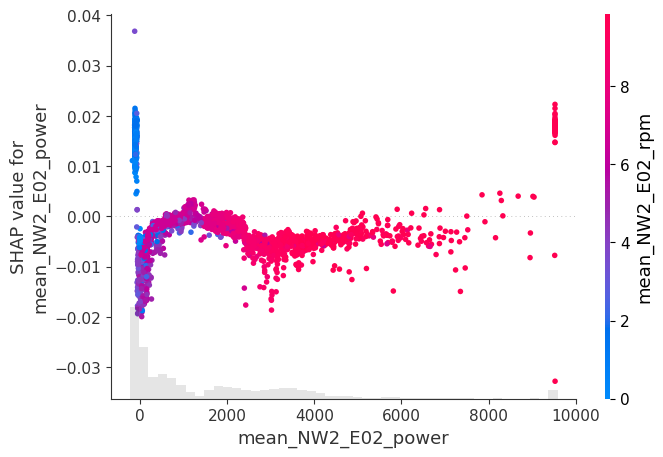

In [15]:
shap.plots.scatter(shap_values[:,"mean_NW2_E02_power"], color=shap_values[:,"mean_NW2_E02_rpm"])

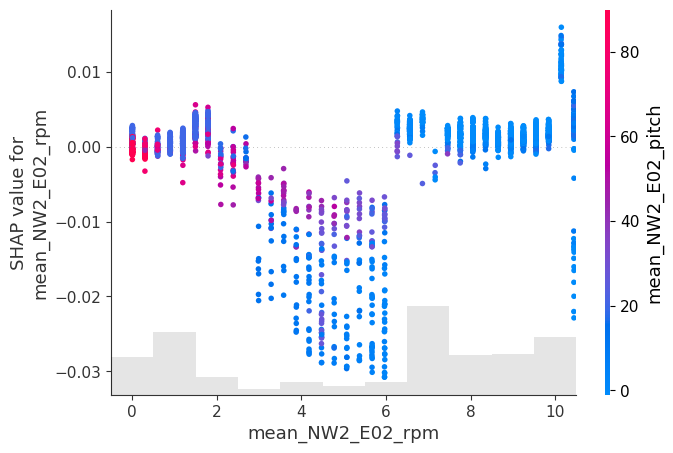

In [16]:
shap.plots.scatter(shap_values[:,"mean_NW2_E02_rpm"], color=shap_values[:,"mean_NW2_E02_pitch"])

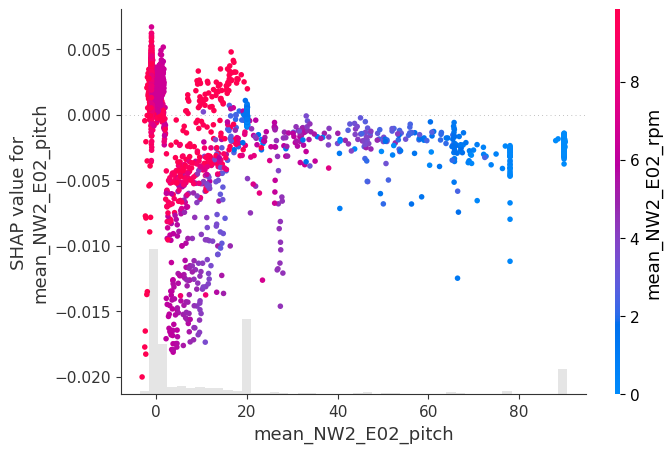

In [17]:
shap.plots.scatter(shap_values[:,"mean_NW2_E02_pitch"], color=shap_values[:,"mean_NW2_E02_rpm"])

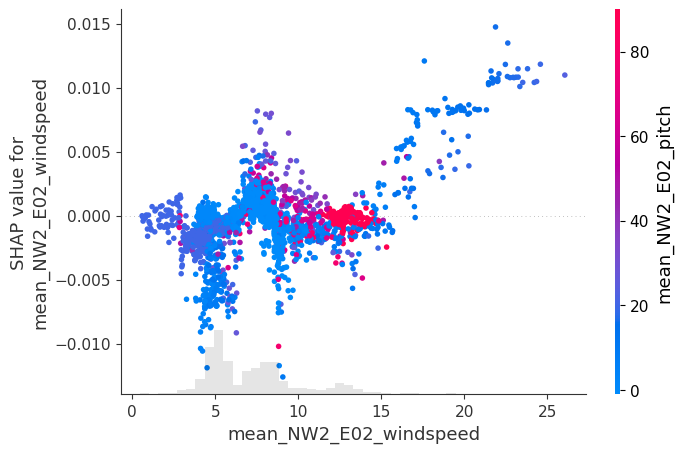

In [18]:
shap.plots.scatter(shap_values[:,"mean_NW2_E02_windspeed"], color=shap_values[:,"mean_NW2_E02_pitch"])

In [19]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values.values[0:1000,:], regr_xgb_optimized['preprocessing_angles'].transform(X).iloc[0:1000,:])

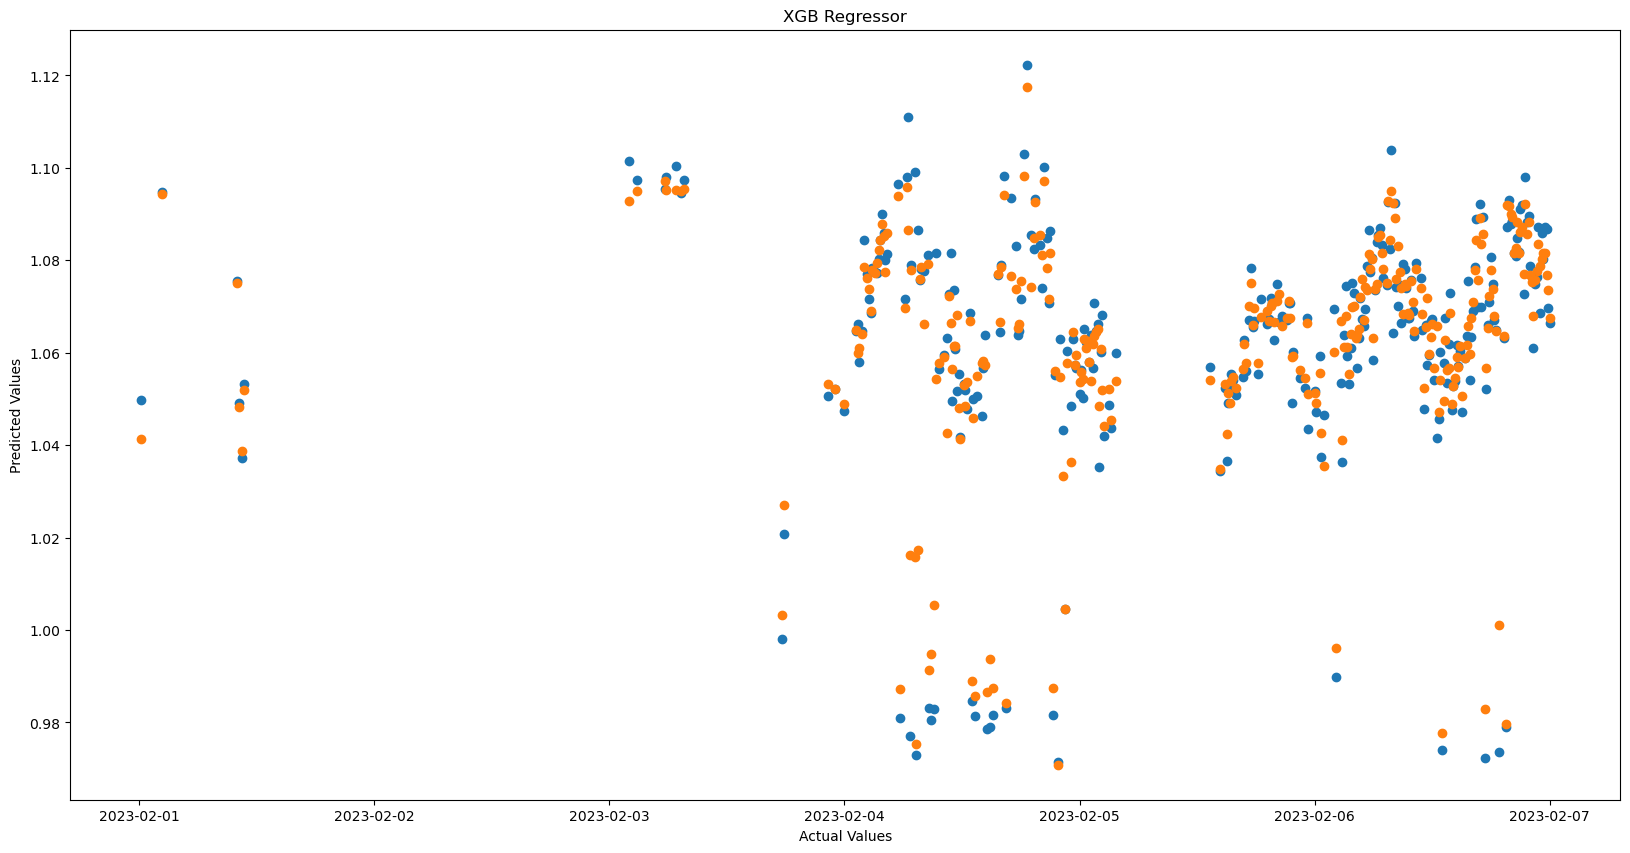

In [20]:
# Create scatter plot of predicted vs. actual values for best xgb regressor
start_plot = datetime.datetime(2023,2,1,tzinfo=utc)
stop_plot = datetime.datetime(2023,2,7,tzinfo=utc)


plt.figure(figsize=(20, 10))
plt.scatter(y.loc[start_plot:stop_plot].index, y.loc[start_plot:stop_plot], label='Actual Values')
plt.scatter(y.loc[start_plot:stop_plot].index, pd.DataFrame(regr_xgb.predict(X), index=X.index).loc[start_plot:stop_plot], label='Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGB Regressor')
plt.show()

In [21]:
dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()

In [22]:
location = locations[0]
metrics = owi.metrics(locations=location)['metric'].values
print(location)
print(metrics)
owi.query(
    (datetime.datetime(2023, 6, 1, tzinfo=utc), datetime.datetime(2023, 6, 2, tzinfo=utc)),
    location=location,
    metrics=metrics
)

nw2e02
['mean_NW2_E02_rpm' 'mean_NW2_E02_yaw' 'std_NW2_E02_pitch'
 'mean_NW2_E02_pitch' 'mean_NW2_E02_power' 'std_NW2_E02_towerxacc'
 'std_NW2_E02_toweryacc' 'std_NW2_E02_windspeed' 'mean_NW2_E02_towerxacc'
 'mean_NW2_E02_toweryacc' 'mean_NW2_E02_windspeed'
 'mean_NW2_E02_winddirection']


,location,mean_NW2_E02_rpm,mean_NW2_E02_yaw,std_NW2_E02_pitch,mean_NW2_E02_pitch,mean_NW2_E02_power,std_NW2_E02_windspeed,mean_NW2_E02_windspeed,mean_NW2_E02_winddirection
timestamp,,,,,,,,,
2023-06-01 00:00:00+00:00,NW2E02,0.0,38.775,0.000000,90.140,-27.328,1.840,11.391,38.076
2023-06-01 00:10:00+00:00,NW2E02,0.0,37.125,0.032429,90.140,-27.264,1.793,11.012,37.488
2023-06-01 00:20:00+00:00,NW2E02,0.0,32.788,0.000000,90.140,-30.080,2.148,12.078,34.159
2023-06-01 00:30:00+00:00,NW2E02,0.0,37.181,0.078075,90.196,-27.392,1.879,10.691,36.789
2023-06-01 00:40:00+00:00,NW2E02,0.0,35.362,0.000000,90.196,-28.672,1.996,11.523,34.971
...,...,...,...,...,...,...,...,...,...
2023-06-01 23:20:00+00:00,NW2E02,0.0,29.487,0.034740,90.140,-27.520,2.012,9.430,28.396
2023-06-01 23:30:00+00:00,NW2E02,0.0,28.284,0.007180,90.140,-28.096,1.961,9.191,30.131
2023-06-01 23:40:00+00:00,NW2E02,0.0,35.950,0.049916,90.140,-27.968,2.070,10.492,37.153


In [23]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = data_root + "data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = data_root + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)